In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

## Dataset Stucture

In [5]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_df = pd.read_csv(annotations_file, sep=" ", header = None)
        self.img_df.columns = ["file_path", "img_label"]
#         self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(self.img_df.iloc[idx, 0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image,(64,64))
#         image = image.transpose((0, 3, 1, 2))
        label = self.img_df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
#         sample = {"image": image, "label": label}
        return image, label

## Model Stucture

In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*13*13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, 16*13*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Read Data

In [7]:
use_gpu = torch.cuda.is_available()

In [8]:
### train
train_path = "train.txt"
train_dataset = ImageDataset(train_path)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)


### validation
val_path = "val.txt"
val_dataset = ImageDataset(val_path)
val_dataloader = DataLoader(val_dataset, batch_size=450)


### test
test_path = "test.txt"
test_dataset = ImageDataset(test_path)
test_dataloader = DataLoader(test_dataset, batch_size=450)

## Train Model 

In [34]:
model = LeNet5()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))


def weight_init(m):
# 使用isinstance来判断m属于什么类型
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
# m中的weight，bias其实都是Variable，为了能学习参数以及后向传播
       m.weight.data.fill_(1)
       m.bias.data.zero_()

model.apply(weight_init)


epoch_tr_acc = []
epoch_tr_loss = []
epoch_test_acc = []
epoch_test_loss = []

for epoch in range(1, 301):
    train_loss = []
    train_acc = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        model.train()
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        data = data.permute(0,3,1,2).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        tr_acc = 100. * correct / len(data)

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.data.item()))


        train_loss.append(loss.data.item())
        train_acc.append(tr_acc)
    
    epoch_tr_acc.append(np.mean(train_acc))
    epoch_tr_loss.append(np.mean(train_loss))
    
    
    ### evaluate validation set
    model.eval()
    val_loss = 0
    val_correct = 0
    for data, target in val_dataloader:
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        data = data.permute(0,3,1,2).float()
        output = model(data)
        val_loss += criterion(output, target).data.item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        val_correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(val_dataloader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, val_correct, len(val_dataloader.dataset),
        100. * val_correct / len(val_dataloader.dataset)))

    val_acc = 100. * val_correct / len(val_dataloader.dataset)
    
    epoch_test_acc.append(val_acc)
    epoch_test_loss.append(val_loss)

USE GPU
Train Epoch: 1 [0/63325 (0%)]	Loss: 4787.443359
Train Epoch: 1 [25600/63325 (40%)]	Loss: 976.420288
Train Epoch: 1 [51200/63325 (81%)]	Loss: 930.257568


/home/ncku02/miniconda3/envs/pytorch_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Validation set: Average loss: 3.5457, Accuracy: 48/450 (10.67%)

Train Epoch: 2 [0/63325 (0%)]	Loss: 889.014160
Train Epoch: 2 [25600/63325 (40%)]	Loss: 850.075073
Train Epoch: 2 [51200/63325 (81%)]	Loss: 896.815552

Validation set: Average loss: 3.2529, Accuracy: 70/450 (15.56%)

Train Epoch: 3 [0/63325 (0%)]	Loss: 806.520142
Train Epoch: 3 [25600/63325 (40%)]	Loss: 819.876465
Train Epoch: 3 [51200/63325 (81%)]	Loss: 780.538025

Validation set: Average loss: 3.1521, Accuracy: 76/450 (16.89%)

Train Epoch: 4 [0/63325 (0%)]	Loss: 775.609314
Train Epoch: 4 [25600/63325 (40%)]	Loss: 738.895325
Train Epoch: 4 [51200/63325 (81%)]	Loss: 749.143921

Validation set: Average loss: 3.0796, Accuracy: 87/450 (19.33%)

Train Epoch: 5 [0/63325 (0%)]	Loss: 727.678223
Train Epoch: 5 [25600/63325 (40%)]	Loss: 704.686890
Train Epoch: 5 [51200/63325 (81%)]	Loss: 689.958801

Validation set: Average loss: 3.1104, Accuracy: 83/450 (18.44%)

Train Epoch: 6 [0/63325 (0%)]	Loss: 676.869995
Train Epoch: 6 [256

Train Epoch: 39 [25600/63325 (40%)]	Loss: 189.099960
Train Epoch: 39 [51200/63325 (81%)]	Loss: 159.494888

Validation set: Average loss: 10.7475, Accuracy: 61/450 (13.56%)

Train Epoch: 40 [0/63325 (0%)]	Loss: 136.280762
Train Epoch: 40 [25600/63325 (40%)]	Loss: 164.096207
Train Epoch: 40 [51200/63325 (81%)]	Loss: 185.384476

Validation set: Average loss: 10.8830, Accuracy: 61/450 (13.56%)

Train Epoch: 41 [0/63325 (0%)]	Loss: 147.552322
Train Epoch: 41 [25600/63325 (40%)]	Loss: 165.739578
Train Epoch: 41 [51200/63325 (81%)]	Loss: 221.877731

Validation set: Average loss: 10.2629, Accuracy: 64/450 (14.22%)

Train Epoch: 42 [0/63325 (0%)]	Loss: 166.190186
Train Epoch: 42 [25600/63325 (40%)]	Loss: 194.382629
Train Epoch: 42 [51200/63325 (81%)]	Loss: 160.574249

Validation set: Average loss: 11.7070, Accuracy: 57/450 (12.67%)

Train Epoch: 43 [0/63325 (0%)]	Loss: 158.012573
Train Epoch: 43 [25600/63325 (40%)]	Loss: 184.900375
Train Epoch: 43 [51200/63325 (81%)]	Loss: 186.433884

Validatio

Train Epoch: 76 [51200/63325 (81%)]	Loss: 131.600723

Validation set: Average loss: 18.4425, Accuracy: 51/450 (11.33%)

Train Epoch: 77 [0/63325 (0%)]	Loss: 113.516235
Train Epoch: 77 [25600/63325 (40%)]	Loss: 92.016586
Train Epoch: 77 [51200/63325 (81%)]	Loss: 106.186089

Validation set: Average loss: 17.6558, Accuracy: 51/450 (11.33%)

Train Epoch: 78 [0/63325 (0%)]	Loss: 219.858673
Train Epoch: 78 [25600/63325 (40%)]	Loss: 108.707962
Train Epoch: 78 [51200/63325 (81%)]	Loss: 106.046707

Validation set: Average loss: 17.8756, Accuracy: 44/450 (9.78%)

Train Epoch: 79 [0/63325 (0%)]	Loss: 114.855194
Train Epoch: 79 [25600/63325 (40%)]	Loss: 85.957535
Train Epoch: 79 [51200/63325 (81%)]	Loss: 95.697525

Validation set: Average loss: 17.6455, Accuracy: 53/450 (11.78%)

Train Epoch: 80 [0/63325 (0%)]	Loss: 112.107834
Train Epoch: 80 [25600/63325 (40%)]	Loss: 108.191231
Train Epoch: 80 [51200/63325 (81%)]	Loss: 96.398590

Validation set: Average loss: 18.5557, Accuracy: 51/450 (11.33%)

T


Validation set: Average loss: 23.1881, Accuracy: 45/450 (10.00%)

Train Epoch: 114 [0/63325 (0%)]	Loss: 75.931610
Train Epoch: 114 [25600/63325 (40%)]	Loss: 83.309471
Train Epoch: 114 [51200/63325 (81%)]	Loss: 80.082550

Validation set: Average loss: 23.5641, Accuracy: 50/450 (11.11%)

Train Epoch: 115 [0/63325 (0%)]	Loss: 76.457779
Train Epoch: 115 [25600/63325 (40%)]	Loss: 87.786392
Train Epoch: 115 [51200/63325 (81%)]	Loss: 104.106827

Validation set: Average loss: 23.5437, Accuracy: 43/450 (9.56%)

Train Epoch: 116 [0/63325 (0%)]	Loss: 66.727249
Train Epoch: 116 [25600/63325 (40%)]	Loss: 77.297592
Train Epoch: 116 [51200/63325 (81%)]	Loss: 141.361328

Validation set: Average loss: 23.0744, Accuracy: 44/450 (9.78%)

Train Epoch: 117 [0/63325 (0%)]	Loss: 68.229637
Train Epoch: 117 [25600/63325 (40%)]	Loss: 103.101059
Train Epoch: 117 [51200/63325 (81%)]	Loss: 74.862526

Validation set: Average loss: 24.1524, Accuracy: 50/450 (11.11%)

Train Epoch: 118 [0/63325 (0%)]	Loss: 80.491547



Validation set: Average loss: 25.8542, Accuracy: 39/450 (8.67%)

Train Epoch: 151 [0/63325 (0%)]	Loss: 99.433746
Train Epoch: 151 [25600/63325 (40%)]	Loss: 58.642197
Train Epoch: 151 [51200/63325 (81%)]	Loss: 66.242561

Validation set: Average loss: 25.5740, Accuracy: 44/450 (9.78%)

Train Epoch: 152 [0/63325 (0%)]	Loss: 56.291626
Train Epoch: 152 [25600/63325 (40%)]	Loss: 51.902393
Train Epoch: 152 [51200/63325 (81%)]	Loss: 105.847809

Validation set: Average loss: 26.9424, Accuracy: 48/450 (10.67%)

Train Epoch: 153 [0/63325 (0%)]	Loss: 92.379150
Train Epoch: 153 [25600/63325 (40%)]	Loss: 82.117271
Train Epoch: 153 [51200/63325 (81%)]	Loss: 93.029076

Validation set: Average loss: 27.0288, Accuracy: 52/450 (11.56%)

Train Epoch: 154 [0/63325 (0%)]	Loss: 39.372379
Train Epoch: 154 [25600/63325 (40%)]	Loss: 52.495674
Train Epoch: 154 [51200/63325 (81%)]	Loss: 194.333618

Validation set: Average loss: 25.5847, Accuracy: 47/450 (10.44%)

Train Epoch: 155 [0/63325 (0%)]	Loss: 93.224121
T


Validation set: Average loss: 29.6959, Accuracy: 44/450 (9.78%)

Train Epoch: 188 [0/63325 (0%)]	Loss: 78.850441
Train Epoch: 188 [25600/63325 (40%)]	Loss: 51.546329
Train Epoch: 188 [51200/63325 (81%)]	Loss: 107.797325

Validation set: Average loss: 29.4742, Accuracy: 37/450 (8.22%)

Train Epoch: 189 [0/63325 (0%)]	Loss: 144.705139
Train Epoch: 189 [25600/63325 (40%)]	Loss: 34.784229
Train Epoch: 189 [51200/63325 (81%)]	Loss: 82.651260

Validation set: Average loss: 29.2922, Accuracy: 40/450 (8.89%)

Train Epoch: 190 [0/63325 (0%)]	Loss: 100.896767
Train Epoch: 190 [25600/63325 (40%)]	Loss: 27.770773
Train Epoch: 190 [51200/63325 (81%)]	Loss: 80.417900

Validation set: Average loss: 29.6460, Accuracy: 49/450 (10.89%)

Train Epoch: 191 [0/63325 (0%)]	Loss: 96.228432
Train Epoch: 191 [25600/63325 (40%)]	Loss: 114.844727
Train Epoch: 191 [51200/63325 (81%)]	Loss: 119.512032

Validation set: Average loss: 29.3233, Accuracy: 48/450 (10.67%)

Train Epoch: 192 [0/63325 (0%)]	Loss: 66.857613

Train Epoch: 225 [0/63325 (0%)]	Loss: 66.993889
Train Epoch: 225 [25600/63325 (40%)]	Loss: 75.627563
Train Epoch: 225 [51200/63325 (81%)]	Loss: 59.726440

Validation set: Average loss: 32.6922, Accuracy: 44/450 (9.78%)

Train Epoch: 226 [0/63325 (0%)]	Loss: 135.656601
Train Epoch: 226 [25600/63325 (40%)]	Loss: 61.051182
Train Epoch: 226 [51200/63325 (81%)]	Loss: 115.138443

Validation set: Average loss: 34.5245, Accuracy: 51/450 (11.33%)

Train Epoch: 227 [0/63325 (0%)]	Loss: 64.061943
Train Epoch: 227 [25600/63325 (40%)]	Loss: 52.501175
Train Epoch: 227 [51200/63325 (81%)]	Loss: 71.654305

Validation set: Average loss: 33.4730, Accuracy: 52/450 (11.56%)

Train Epoch: 228 [0/63325 (0%)]	Loss: 48.226673
Train Epoch: 228 [25600/63325 (40%)]	Loss: 50.567001
Train Epoch: 228 [51200/63325 (81%)]	Loss: 88.195663

Validation set: Average loss: 31.8523, Accuracy: 51/450 (11.33%)

Train Epoch: 229 [0/63325 (0%)]	Loss: 104.912300
Train Epoch: 229 [25600/63325 (40%)]	Loss: 66.102386
Train Epoch: 

Train Epoch: 262 [25600/63325 (40%)]	Loss: 75.394852
Train Epoch: 262 [51200/63325 (81%)]	Loss: 93.751610

Validation set: Average loss: 36.1239, Accuracy: 49/450 (10.89%)

Train Epoch: 263 [0/63325 (0%)]	Loss: 47.046967
Train Epoch: 263 [25600/63325 (40%)]	Loss: 62.887928
Train Epoch: 263 [51200/63325 (81%)]	Loss: 43.687893

Validation set: Average loss: 37.5823, Accuracy: 49/450 (10.89%)

Train Epoch: 264 [0/63325 (0%)]	Loss: 117.548462
Train Epoch: 264 [25600/63325 (40%)]	Loss: 72.465385
Train Epoch: 264 [51200/63325 (81%)]	Loss: 44.724155

Validation set: Average loss: 36.4910, Accuracy: 42/450 (9.33%)

Train Epoch: 265 [0/63325 (0%)]	Loss: 134.694672
Train Epoch: 265 [25600/63325 (40%)]	Loss: 33.833855
Train Epoch: 265 [51200/63325 (81%)]	Loss: 51.213009

Validation set: Average loss: 34.9812, Accuracy: 48/450 (10.67%)

Train Epoch: 266 [0/63325 (0%)]	Loss: 51.195576
Train Epoch: 266 [25600/63325 (40%)]	Loss: 98.172264
Train Epoch: 266 [51200/63325 (81%)]	Loss: 56.900585

Validati

Train Epoch: 299 [51200/63325 (81%)]	Loss: 71.069298

Validation set: Average loss: 37.5433, Accuracy: 47/450 (10.44%)

Train Epoch: 300 [0/63325 (0%)]	Loss: 41.503315
Train Epoch: 300 [25600/63325 (40%)]	Loss: 140.964798
Train Epoch: 300 [51200/63325 (81%)]	Loss: 62.850010

Validation set: Average loss: 36.7318, Accuracy: 44/450 (9.78%)



In [35]:
### evaluate test set
model.eval()
test_loss = 0
correct = 0
for data, target in test_dataloader:
    if use_gpu:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    data = data.permute(0,3,1,2).float()
    output = model(data)
    test_loss += criterion(output, target).data.item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

test_loss /= len(test_dataloader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))

test_acc = correct / len(test_dataloader.dataset)


Test set: Average loss: 36.0062, Accuracy: 57/450 (12.67%)



/home/ncku02/miniconda3/envs/pytorch_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [45]:
### evaluate test set
model.eval()
test_loss = 0
correct = 0
for data, target in val_dataloader:
    if use_gpu:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    data = data.permute(0,3,1,2).float()
    output = model(data)
    test_loss += criterion(output, target).data.item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

test_loss /= len(val_dataloader.dataset)
print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    val_loss, correct, len(val_dataloader.dataset),
    100. * correct / len(val_dataloader.dataset)))

val_acc = correct / len(val_dataloader.dataset)


Val set: Average loss: 36.7318, Accuracy: 44/450 (9.78%)



/home/ncku02/miniconda3/envs/pytorch_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


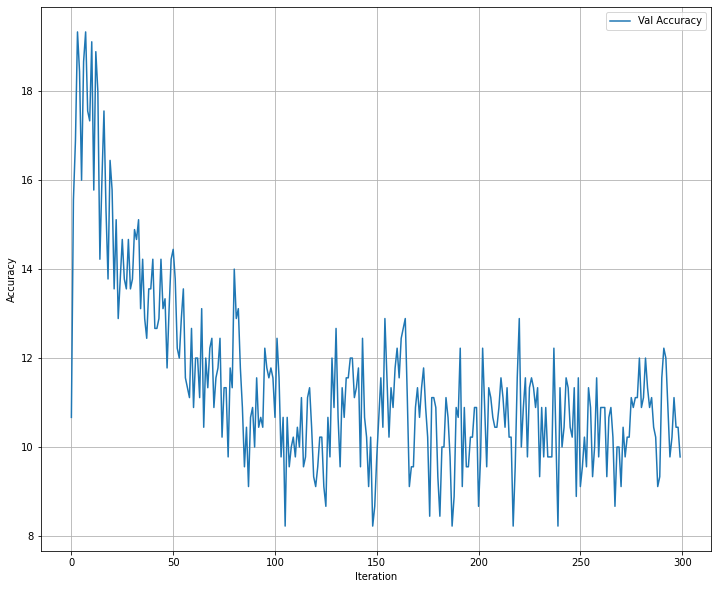

In [41]:
### plot acc plot
fig,ax = plt.subplots(1,1,figsize=(12,10))
# ax.plot(epoch_tr_acc,label="Train Accuracy")
ax.plot(epoch_test_acc,label="Val Accuracy")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid()

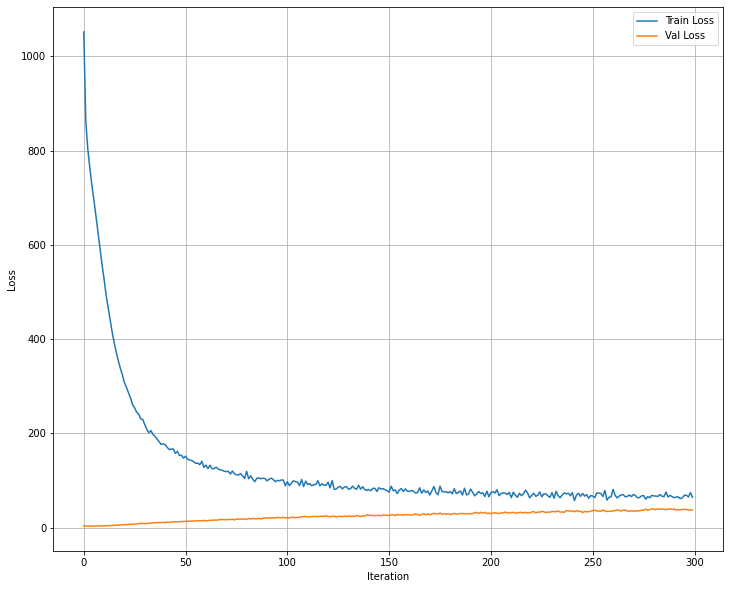

In [44]:
### plot loss plot
fig,ax = plt.subplots(1,1,figsize=(12,10))
ax.plot(epoch_tr_loss,label="Train Loss")
ax.plot(epoch_test_loss,label="Val Loss")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()